# Artigo Induscon 2023

## Pre processamento

Pré-processamento dos dados de pesquisa no IEEE Xplore obtidos com os seguintes filtros:

- Search terms: "OPC UA"
- Language: English
- Date range: Last 5 years

#### Importação dos pacotes

In [116]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

#### Carregando as bases de dados

Base dos dados obtidos na primeira pesquisa já classificados.

In [117]:
df = pd.read_excel('Build/opcua5years_pre2.xlsm')
drop_labels = ['Author Affiliations','Date Added To Xplore','Volume',
               'Issue','Start Page','End Page','ISSN','ISBNs','DOI',
               'Funding Information','PDF Link','INSPEC Controlled Terms',
               'INSPEC Non-Controlled Terms','Mesh_Terms','Article Citation Count',
               'Patent Citation Count','Reference Count','License','Online Date',
               'Issue Date','Meeting Date','Publisher']
classified = df.drop(labels=drop_labels, axis=1)
classified['Category'] = list(classified['Category'].str.split(";", expand=False))
classified['Authors'] = list(classified['Authors'].str.split(";", expand=False))
classified.index += 2
classified.head(2)

,Category,Document Title,Authors,Publication Title,Publication Year,Abstract,Author Keywords,IEEE Terms,Document Identifier
2,[Product Development (PD)],Towards a Web-of-Things Approach for OPC UA Fi...,"[Q. -D. Nguyen, S. Dhouib, J. -P. Chanet, P...",2022 IEEE 18th International Conference on Fac...,2022,"In the opc UA standard, the opc UA information...",Industry;Internet of Things;OPC UA;Web of Thin...,Runtime;Conferences;Semantics;Manuals;Producti...,IEEE Conferences
3,[Redundancy and Availability (RA)],Practical Implementation of an OPC UA Multi-Se...,"[C. Pu, X. Ding, P. Wang, Y. Yang]",2022 IEEE International Conferences on Interne...,2022,The Open Platform Communication Unified Archit...,automated industry;OPC UA;TSN;server aggregation,Social computing;Data security;Configuration m...,IEEE Conferences


Base de dados obtida na segunda pesquisa, com os seguintes filtros:

- Search terms: "OPC UA" in Author Keywords
- Language: English
- Date range: Last 5 years

In [118]:
df = pd.read_csv('Build/opcua5years_keywords.csv')
new_query = df.drop(labels=drop_labels+['Authors','Publication Title','Publication Year','Abstract','Author Keywords','IEEE Terms','Document Identifier'], axis=1)
new_query_titles = new_query['Document Title'].tolist()

Dataframe com a base de dados já classificada e filtrada para aquelas que apenas tem OPC UA no Author Keywords

In [119]:
filtered_classified = classified[classified['Document Title'].isin(new_query_titles)]
filtered_classified.to_csv('filtered_classified.csv',sep=',',encoding='UTF-8')
filtered_classified.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252 entries, 2 to 326
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Category             252 non-null    object
 1   Document Title       252 non-null    object
 2   Authors              252 non-null    object
 3   Publication Title    252 non-null    object
 4   Publication Year     252 non-null    int64 
 5   Abstract             252 non-null    object
 6   Author Keywords      252 non-null    object
 7   IEEE Terms           235 non-null    object
 8   Document Identifier  252 non-null    object
dtypes: int64(1), object(8)
memory usage: 19.7+ KB


Separação dos dados em categorias (EXPLODE)

In [120]:
def explode(df, lst_cols, fill_value='', preserve_index=False):
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    idx_cols = df.columns.difference(lst_cols)
    lens = df[lst_cols[0]].str.len()
    idx = np.repeat(df.index.values, lens)
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    if (lens == 0).any():
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    res = res.sort_index()
    if not preserve_index:
        res = res.reset_index(drop=True)
    return res

In [121]:
classified_explode_categories = filtered_classified.explode('Category')
classified_explode_categories['Category'].value_counts()

Category
Product Development (PD)            110
Integration (I)                      58
Others (O)                           54
Performance Analysis (PA)            41
Diagnostic and Monitoring (DM)       39
Protocol Comparison (PC)             36
Wireless Communication (W)           26
Theory (T)                           25
Security (S)                         23
Redundancy and Availability (RA)      9
Name: count, dtype: int64

## Consultas

Realizar as consultas na base para construir tabelas e gráficos da seção **Quantitative Analysis**

#### Número de publicações relacionadas com OPC UA por ano

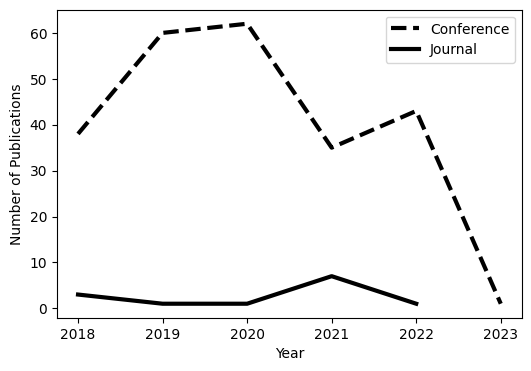

In [122]:
grouped = filtered_classified.groupby(['Publication Year', 'Document Identifier']).size().reset_index(name='Count')
pivot = grouped.pivot(index='Publication Year', columns='Document Identifier', values='Count')
plt.figure(figsize=(6, 4))
# lines = pivot.plot(kind='line',linewidth=3)
plt.plot(pivot.index, pivot['IEEE Conferences'], linestyle='--', color='black', linewidth=3, label='Conference')
plt.plot(pivot.index, pivot['IEEE Journals'], linestyle='-', color='black', linewidth=3, label='Journal')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.legend(title='', loc='upper right')
plt.show()

#### Quantidade de artigos por categorias (Tabela)

In [123]:
grouped = classified_explode_categories.groupby(['Publication Year', 'Category']).size().reset_index(name='Count')
pivot = grouped.pivot(index='Publication Year', columns='Category', values='Count')
pivot

Category,Diagnostic and Monitoring (DM),Integration (I),Others (O),Performance Analysis (PA),Product Development (PD),Protocol Comparison (PC),Redundancy and Availability (RA),Security (S),Theory (T),Wireless Communication (W)
Publication Year,,,,,,,,,,
2018,6.0,11.0,7.0,6.0,19.0,3.0,2.0,3.0,3.0,1.0
2019,10.0,13.0,16.0,9.0,28.0,9.0,1.0,6.0,6.0,8.0
2020,15.0,15.0,19.0,8.0,22.0,11.0,3.0,5.0,6.0,6.0
2021,3.0,11.0,3.0,11.0,20.0,6.0,1.0,4.0,4.0,6.0
2022,5.0,7.0,9.0,7.0,21.0,7.0,2.0,5.0,6.0,4.0
2023,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
